<a href="https://colab.research.google.com/github/rbbh/SVR-PSO/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [3]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [0]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))

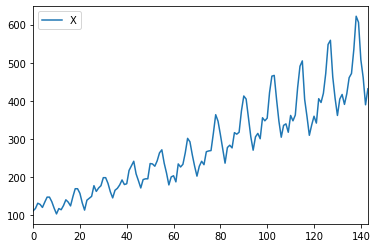

In [5]:
data.plot()


In [6]:
# Lag used for the prediction
# We will use 12 for the lag because 
# the series repeats itself annually

dimensions = 12
data_c = pd.concat([data.shift(i) for i in range(0 + dimensions + 1)], axis = 1)
print(data_c)

       X      X      X      X      X  ...      X      X      X      X      X
0    112    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
1    118  112.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2    132  118.0  112.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3    129  132.0  118.0  112.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
4    121  129.0  132.0  118.0  112.0  ...    NaN    NaN    NaN    NaN    NaN
..   ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
139  606  622.0  535.0  472.0  461.0  ...  405.0  362.0  407.0  463.0  559.0
140  508  606.0  622.0  535.0  472.0  ...  417.0  405.0  362.0  407.0  463.0
141  461  508.0  606.0  622.0  535.0  ...  391.0  417.0  405.0  362.0  407.0
142  390  461.0  508.0  606.0  622.0  ...  419.0  391.0  417.0  405.0  362.0
143  432  390.0  461.0  508.0  606.0  ...  461.0  419.0  391.0  417.0  405.0

[144 rows x 13 columns]


In [0]:
# Normalizing the data

data_c = data_c/data_c.max() 

In [8]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_c.iloc[12:,1:]
y = data_c.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))



26
27
79


In [0]:
# Function that displays tridimensional plot
def plot(some_list):
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-1
    max_e = 1e-1
    min_e = 1e-4
    max_g = 1e0
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    # TODO: Create function for thresholds
    threshold = 10e100
    threshold2 = 10e100
    threshold3 = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):
        p_bests = []
        #av_pbest = []
        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best position to the Group's best
              g_best = p_best[aux].copy()
              

          p_bests.append(p_best[j])  
          
        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val

        # The variable below represents the average of all the particles'
        # locations on the current iteration
        av_pbest = sum(p_bests)/n_particles

        #TODO: Calculate the median of all the particles' locations
        #sorted_pbests[i] = p_bests.sort()
        #length = len(p_bests)

        #if(length % 2 == 0):
          #median = (sorted_pbests[(length)//2] + sorted_pbests[(length)//2-1]) / 2  
        #else:
          #median = sorted_pbests[(length-1)//2]

        print('Best value iteration # %d = %f\n'%(i, g_best_val))

        i = 0
        
        #print(av_pbest)
        #print(av_pbest[i])
        #print(av_pbest[i+1])
        #print(av_pbest[i+2])

        # TODO: display the median
        #print('Median Particle Best value iteration # %d = %f\n'%(i, median))

        rgs_av = svm.SVR(C = av_pbest[i], epsilon = av_pbest[i+1], gamma = av_pbest[i+2])
        
        rgs_av.fit(X_train, y_train)
        y_predict = rgs_av.predict(X_val)
        mse2 = mean_squared_error(y_val, y_predict) 

        if(mse2 < threshold2):
          threshold2 = mse2
          bestRGS_av = rgs_av

        #rgs_md = svm.SVR(C = median[i][0], epsilon = median[i][1], gamma = median[i][2])
        
        #rgs_md.fit(X_train, y_train)
        #y_predict = rgs_md.predict(X_val)
        #mse3 = mean_squared_error(y_val, y_predict)

        #if(mse3 < threshold3):
          #threshold3 = mse3
          #bestRGS_md = rgs_md

        
    # Coordinates found after all the iterations
    print('Group Best value found: ')
    print(g_best)
    print('Final Average value found: ')
    print(av_pbest)
    #print('Final Median value found')
    #print(median)


    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test= bestRGS.predict(X_test)

    # Displaying actual values and predicted values in a graph
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, predict_test)
    print('Least mean squared error: %f' %mse)

    #t = range(len(y_test))
    #plt.plot(t, mse, label='Error')
    #plt.legend()
    #plt.show()

    predict_test= bestRGS_av.predict(X_test)

    # Displaying actual values and predicted values in a graph for
    # the average values
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted with Average Values')
    plt.legend()
    plt.show()

    mse2 = mean_squared_error(y_test, predict_test)
    print('Least mean squared error for the average values: %f' %mse2)

    #t = range(len(y_test))
    #plt.plot(t, mse2, label='Error')
    #plt.legend()
    #plt.show()

    #mse3 = mean_squared_error(y_test, predict_test)
    #print(mse3)

    #t = range(len(y_test))
    #plt.plot(t, mse3, label='Error')
    #plt.legend()
    #plt.show()

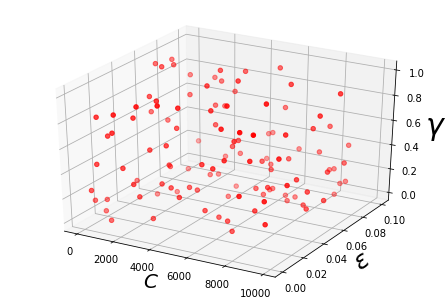

Best value iteration # 0 = 0.000907

Best value iteration # 1 = 0.000872

Best value iteration # 2 = 0.000864

Best value iteration # 3 = 0.000864

Best value iteration # 4 = 0.000864

Best value iteration # 5 = 0.000843

Best value iteration # 6 = 0.000843

Best value iteration # 7 = 0.000843

Best value iteration # 8 = 0.000843

Best value iteration # 9 = 0.000843

Best value iteration # 10 = 0.000843

Best value iteration # 11 = 0.000843

Best value iteration # 12 = 0.000843

Best value iteration # 13 = 0.000843

Best value iteration # 14 = 0.000843

Best value iteration # 15 = 0.000843

Best value iteration # 16 = 0.000818

Best value iteration # 17 = 0.000818

Best value iteration # 18 = 0.000818

Best value iteration # 19 = 0.000818

Best value iteration # 20 = 0.000794

Best value iteration # 21 = 0.000794

Best value iteration # 22 = 0.000794

Best value iteration # 23 = 0.000794

Best value iteration # 24 = 0.000794

Best value iteration # 25 = 0.000794

Best value iteration #

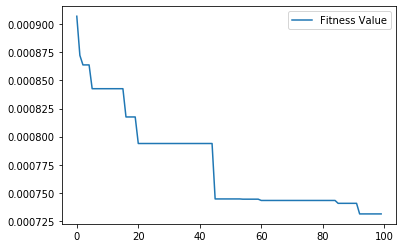

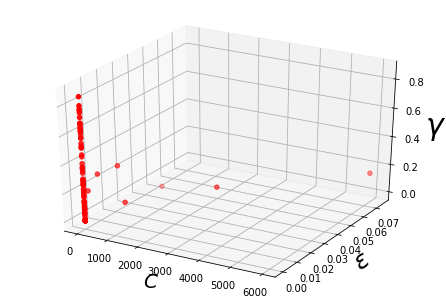

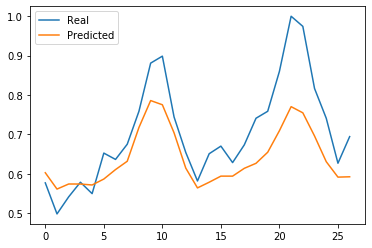

Least mean squared error: 0.009033


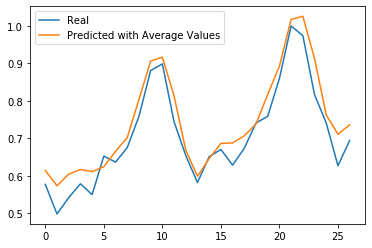

Least mean squared error for the average values: 0.002133


In [35]:
pso(120, 100, 3, 1)

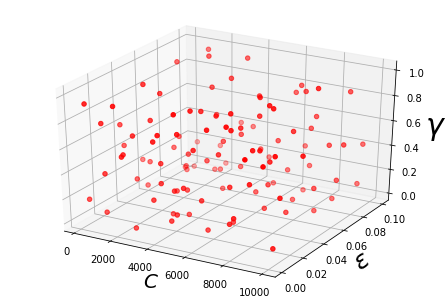

Best value iteration # 0 = 0.000818

Best value iteration # 1 = 0.000818

Best value iteration # 2 = 0.000818

Best value iteration # 3 = 0.000818

Best value iteration # 4 = 0.000818

Best value iteration # 5 = 0.000818

Best value iteration # 6 = 0.000818

Best value iteration # 7 = 0.000818

Best value iteration # 8 = 0.000818

Best value iteration # 9 = 0.000818

Best value iteration # 10 = 0.000818

Best value iteration # 11 = 0.000818

Best value iteration # 12 = 0.000818

Best value iteration # 13 = 0.000818

Best value iteration # 14 = 0.000816

Best value iteration # 15 = 0.000816

Best value iteration # 16 = 0.000816

Best value iteration # 17 = 0.000816

Best value iteration # 18 = 0.000816

Best value iteration # 19 = 0.000816

Best value iteration # 20 = 0.000816

Best value iteration # 21 = 0.000816

Best value iteration # 22 = 0.000816

Best value iteration # 23 = 0.000816

Best value iteration # 24 = 0.000816

Best value iteration # 25 = 0.000815

Best value iteration #

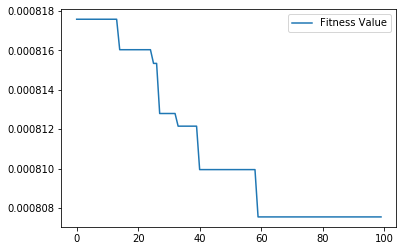

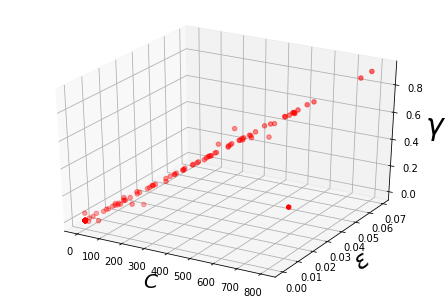

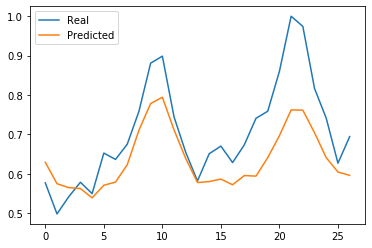

Least mean squared error: 0.009815


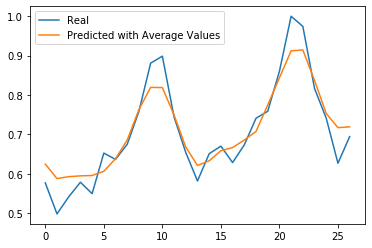

Least mean squared error for the average values: 0.001992


In [36]:
pso(120, 100, 3, 0.8)

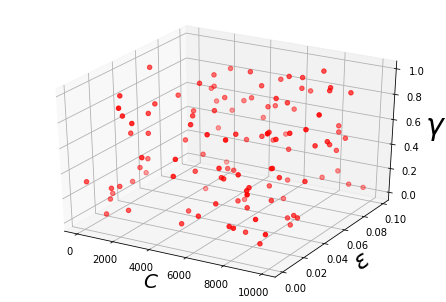

Best value iteration # 0 = 0.000837

Best value iteration # 1 = 0.000837

Best value iteration # 2 = 0.000837

Best value iteration # 3 = 0.000837

Best value iteration # 4 = 0.000829

Best value iteration # 5 = 0.000829

Best value iteration # 6 = 0.000829

Best value iteration # 7 = 0.000829

Best value iteration # 8 = 0.000825

Best value iteration # 9 = 0.000814

Best value iteration # 10 = 0.000811

Best value iteration # 11 = 0.000811

Best value iteration # 12 = 0.000811

Best value iteration # 13 = 0.000811

Best value iteration # 14 = 0.000811

Best value iteration # 15 = 0.000811

Best value iteration # 16 = 0.000811

Best value iteration # 17 = 0.000811

Best value iteration # 18 = 0.000808

Best value iteration # 19 = 0.000808

Best value iteration # 20 = 0.000808

Best value iteration # 21 = 0.000808

Best value iteration # 22 = 0.000808

Best value iteration # 23 = 0.000808

Best value iteration # 24 = 0.000808

Best value iteration # 25 = 0.000808

Best value iteration #

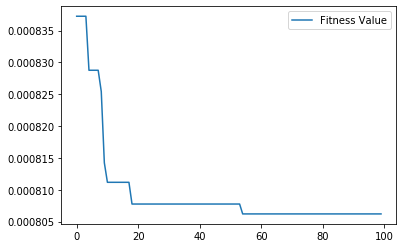

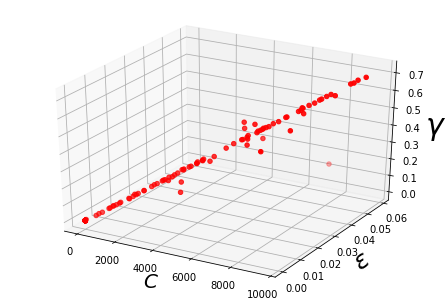

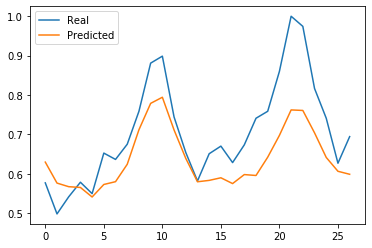

Least mean squared error: 0.009685


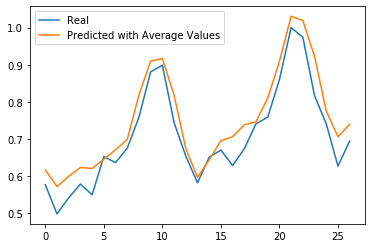

Least mean squared error for the average values: 0.002581


In [37]:
pso(120, 100, 3, 0.6)

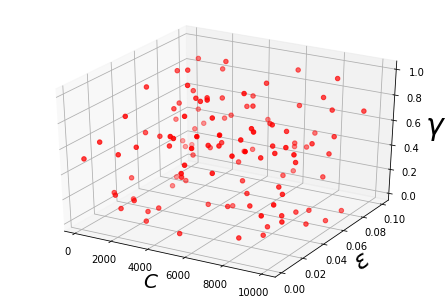

Best value iteration # 0 = 0.000873

Best value iteration # 1 = 0.000873

Best value iteration # 2 = 0.000873

Best value iteration # 3 = 0.000847

Best value iteration # 4 = 0.000825

Best value iteration # 5 = 0.000823

Best value iteration # 6 = 0.000816

Best value iteration # 7 = 0.000816

Best value iteration # 8 = 0.000816

Best value iteration # 9 = 0.000815

Best value iteration # 10 = 0.000813

Best value iteration # 11 = 0.000813

Best value iteration # 12 = 0.000801

Best value iteration # 13 = 0.000801

Best value iteration # 14 = 0.000801

Best value iteration # 15 = 0.000801

Best value iteration # 16 = 0.000801

Best value iteration # 17 = 0.000801

Best value iteration # 18 = 0.000801

Best value iteration # 19 = 0.000801

Best value iteration # 20 = 0.000801

Best value iteration # 21 = 0.000801

Best value iteration # 22 = 0.000801

Best value iteration # 23 = 0.000801

Best value iteration # 24 = 0.000801

Best value iteration # 25 = 0.000801

Best value iteration #

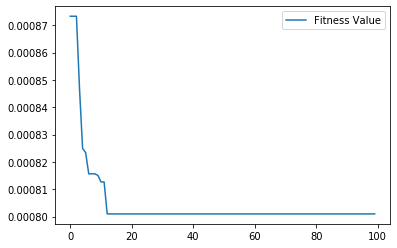

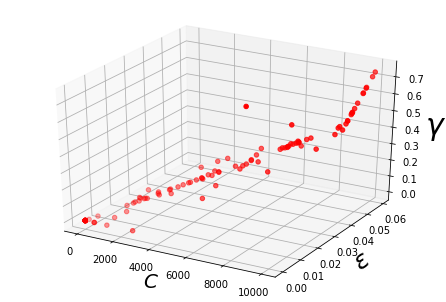

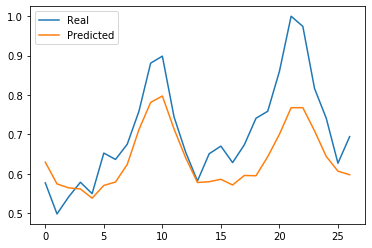

Least mean squared error: 0.009419


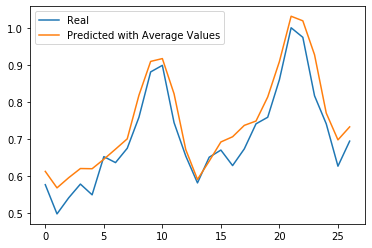

Least mean squared error for the average values: 0.002500


In [38]:
pso(120, 100, 3, 0.2)